In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from tqdm import tqdm

import collections
from random import choice
import copy

from graph_tool.all import *

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


#### Locate folder

In [2]:
source = '/mnt/lynxkite/data/kite_data/upload/'

#### Read all filenames and sort

In [3]:
files = sorted([ i for i in os.listdir(source) if '.csv' in i ])
files = np.array( sorted([ i for i in files if 'output_' in i ]) )
files.shape, files[:3], files[-4:]

((702,),
 array(['output_20180101.csv', 'output_20180102.csv',
        'output_20180103.csv'], dtype='<U19'),
 array(['output_20191130.csv', 'output_total.csv', 'output_year2018.csv',
        'output_year2019.csv'], dtype='<U19'))

In [4]:
files[0], files[334], files[365], files[698]

('output_20180101.csv',
 'output_20181201.csv',
 'output_20190101.csv',
 'output_20191130.csv')

In [5]:
364+31+28+31+30+31+30+31+31+30+31+30

698

#### Select the year 2018

In [6]:
# 2018.12.01-2019.11.30

In [7]:
files_2019 = files[334:]
files_2019.shape

(368,)

In [8]:
df = pd.read_csv( source+files_2019[0], delimiter=',' )
df.head()

,src,dst,traffic
0,39896,42136,17.203232
1,31193,34393,29.172490
2,69953,70914,33.255560
3,39247,38295,21.445524
4,37971,42766,55.472760


In [9]:
df.shape

(100817, 3)

#### Preprocess data to be able to parse it

In [10]:
src_part = df.src.values
dst_part = df.dst.values
weight_part = []
for i in range( df.shape[0] ):
    weight_part.append( '{\'weight\': '+str( np.round( df.traffic[i], 4 ) )[:7]+'}' )
weight_part = np.array( weight_part )
src_part[:3], dst_part[:3], weight_part[:3]

(array([39896, 31193, 69953]),
 array([42136, 34393, 70914]),
 array(["{'weight': 17.2032}", "{'weight': 29.1725}",
        "{'weight': 33.2556}"], dtype='<U19'))

In [11]:
grap_to_parse = []
for i in range( src_part.shape[0] ):
     grap_to_parse.append( str(src_part[i]) + ' ' + str( dst_part[i]) +' ' + weight_part[i] )

In [12]:
grap_to_parse[:5]

["39896 42136 {'weight': 17.2032}",
 "31193 34393 {'weight': 29.1725}",
 "69953 70914 {'weight': 33.2556}",
 "39247 38295 {'weight': 21.4455}",
 "37971 42766 {'weight': 55.4728}"]

#### Creation of graph

In [13]:
G = nx.parse_edgelist( grap_to_parse , delimiter=' ', nodetype=int, create_using=nx.Graph())

#### Check if graph is correct

In [14]:
[ i for i in nx.all_neighbors( G, 39896) ]

[42136, 37656, 37657, 38935, 38938, 37976]

In [15]:
G_nodes_id = np.array( [i[0] for i in G.nodes(True) ] ).astype(int)
G_nodes_df = pd.read_csv( source+'boxids.csv' ).iloc[ G_nodes_id ]
G_nodes_df_header = list( G_nodes_df )
G_nodes_id = G_nodes_df.values

In [ ]:
pd.read_csv( '/mnt/graph_analitics_data/graph_vertex_attr_201' )

In [17]:
G_nodes_df

,boxid,eovx,eovy,lat,lon
39896,39896,260444,550841,47.680270,17.726734
42136,42136,260444,557841,47.681297,17.819951
31193,31193,197444,523841,47.109050,17.385070
34393,34393,197444,533841,47.110888,17.516804
69953,69953,237444,644841,47.480921,18.978995
...,...,...,...,...,...
37608,37608,212444,543841,47.247485,17.644997
42763,42763,247444,559841,47.564663,17.849242
43290,43290,134444,561841,46.548553,17.897921
34117,34117,241444,532841,47.506423,17.492087


In [16]:
G_nodes_id

array([[3.98960000e+04, 2.60444000e+05, 5.50841000e+05, 4.76802703e+01,
        1.77267337e+01],
       [4.21360000e+04, 2.60444000e+05, 5.57841000e+05, 4.76812973e+01,
        1.78199514e+01],
       [3.11930000e+04, 1.97444000e+05, 5.23841000e+05, 4.71090502e+01,
        1.73850699e+01],
       ...,
       [4.32900000e+04, 1.34444000e+05, 5.61841000e+05, 4.65485529e+01,
        1.78979210e+01],
       [3.41170000e+04, 2.41444000e+05, 5.32841000e+05, 4.75064225e+01,
        1.74920870e+01],
       [3.81860000e+04, 1.50444000e+05, 5.45841000e+05, 4.66901561e+01,
        1.76856921e+01]])

##### <font color='red'>42136 </font> is on the list, so it may be correct!

#### Automatization of this process

In [15]:
def create_day_graph_from_csv( path_to_file ):
    df = pd.read_csv( path_to_file, delimiter=',' )
    src_part = df.src.values
    dst_part = df.dst.values
    weight_part = []
    
    for i in range( df.shape[0] ):
        weight_part.append( '{\'weight\': '+str( np.round( df.traffic[i], 4 ) )[:7]+'}' )
    weight_part = np.array( weight_part )
    
    grap_to_parse = []
    for i in range( src_part.shape[0] ):
         grap_to_parse.append( str(src_part[i]) + ' ' + str( dst_part[i]) +' ' + weight_part[i] )
            
    G = nx.parse_edgelist( grap_to_parse , delimiter=' ', nodetype=int, create_using=nx.Graph())
    # graph node id based on cell id
    G_nodes_id = np.array( [i[0] for i in G.nodes(True) ] ).astype(int)
    G_nodes_df = pd.read_csv( source+'boxids.csv' ).iloc[ G_nodes_id ]
    G_nodes_df_header = list( G_nodes_df )
    G_nodes_id = G_nodes_df.values
    
    return G, G_nodes_id, G_nodes_df_header

In [16]:
def degree_centrality( g ):
    return nx.algorithms.degree_centrality( g )

In [17]:
def closeness_centrality( g ):
    return nx.algorithms.centrality.closeness_centrality( g )

In [18]:
def betweenness_centrality( g ):
    return nx.algorithms.centrality.betweenness_centrality( g )

In [19]:
def average_neighbor_degree( g ):
    return nx.algorithms.average_neighbor_degree( g )

In [20]:
def pagerank( g ):
    return nx.pagerank( g )

In [21]:
def clustering( g ):
    return nx.algorithms.cluster.clustering( g )

In [22]:
def susceptibility_chi( conn_comps, size ):
    return np.sum( np.sort( conn_comps )[:-1]**2 ) / size**2 # np.sum( np.square(conn_comps) ) # leaving out the largest conn. comp.

In [23]:
def degree_distribution( g, uplim=100, title='Degree distribution' ):
    degree_sequence = sorted( [ d for n, d in g.degree() ], reverse=True)  

    degreeCount = collections.Counter( degree_sequence )
    degree, count = zip( *degreeCount.items() )

    plt.figure( num=1, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k' )
    plt.bar(degree, count, color='g')
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    #plt.xlim([0,uplim])
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [24]:
G, G_nodes_id, G_nodes_df_header = create_day_graph_from_csv( source+files_2019[0] )

In [25]:
len(G.nodes), len(G.edges)

(21251, 56052)

In [26]:
G_nodes_id[:2]

array([[3.98960000e+04, 2.60444000e+05, 5.50841000e+05, 4.76802703e+01,
        1.77267337e+01],
       [4.21360000e+04, 2.60444000e+05, 5.57841000e+05, 4.76812973e+01,
        1.78199514e+01]])

In [27]:
G_nodes_df_header

['boxid', 'eovx', 'eovy', 'lat', 'lon']

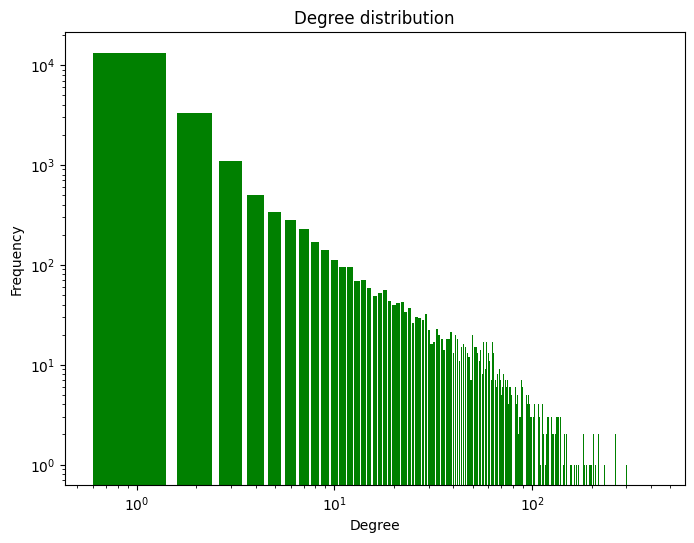

In [28]:
degree_distribution( G )

#### Convert nx graph to Graph-tool graph to get some processing speed increase

https://bbengfort.github.io/snippets/2016/06/23/graph-tool-from-networkx.html (outdated)

https://gist.github.com/tomshaffner/7a2df7f9ec6b1be33dd0413897125683 (updated, works with nx 2.5)

In [29]:
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, str):
        # Encode the key as utf-8
        key = key.encode('utf-8', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, str):
        tname = 'string'
        value = value.encode('utf-8', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)
        
    #If key is a byte value, decode it to string
    try:
        key = key.decode('utf-8')
    except AttributeError:
        pass

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in list(nxG.graph.items()):
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in list(data.items()):            
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in list(data.items()):            
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)
            
            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in list(data.items()):
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in list(data.items()):
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

#### Metrics to be calculated:

In [30]:
def calculate_betweenness(g):
    vertex, edge = betweenness(g)
    return list(vertex)#, list(edge)

In [31]:
def calculate_closeness(g):
    vertex = closeness(g)
    return list(vertex)

In [32]:
def calculate_pagerank(g):
    vertex = pagerank(g)
    return list(vertex)

In [33]:
def calculate_eigenvector(g):
    largest_num, vertex = eigenvector(g)
    return list(vertex)

In [34]:
def calculate_katz(g):
    vertex = katz(g)
    return list(vertex)

In [35]:
def calculate_local_clustering(g):
    vertex = local_clustering(g)
    return list(vertex)

In [36]:
def calculate_motifs(g):
    mots, counts = motifs( g, k=3 )
    return mots, counts

#### Select output folder

In [37]:
destination = '/mnt/graph_analitics_data/'

In [ ]:
for f in tqdm( range( files_2019.shape[0] ) ):
    #print(f)
    # box_id (csúcs), földrajzi koordináták, metrikák
    savename = destination+'graph_vertex_attr_'+files_2019[f].split('.')[0][-8:]+'.csv'
    if not os.path.exists( savename ):

        #read graph from csv file
        day_csv = pd.read_csv( source+files_2019[f] )
        G, G_nodes_id, G_nodes_df_header = create_day_graph_from_csv( path_to_file=source+files_2019[f] )
        # convert to Graph-tool graph object
        gtG = nx2gt(G)

        vertex_attrs = []
        vertex_attrs.append( calculate_betweenness(gtG) )
        vertex_attrs.append( calculate_closeness(gtG) )
        #vertex_attrs.append( calculate_pagerank(gtG) )
        vertex_attrs.append( calculate_eigenvector(gtG) )
        #vertex_attrs.append( calculate_katz(gtG) )
        vertex_attrs.append( calculate_local_clustering(gtG) )

        vertex_attrs = np.array(vertex_attrs).T
        vertex_attrs = np.concatenate( (G_nodes_id, vertex_attrs), axis=1 )
        vertex_df = pd.DataFrame( vertex_attrs, 
                                  columns=(G_nodes_df_header+[ 'betweenness', 'closeness', 'eigenvector', "local_clustering"]) )
        vertex_df.to_csv( savename, index=None )
        #print(vertex_attrs.shape)
    else:
        print('Already processed, skipping!') 

  0%|          | 0/368 [00:00<?, ?it/s]

0


  0%|          | 1/368 [00:20<2:06:16, 20.64s/it]

1


  1%|          | 2/368 [00:35<1:54:30, 18.77s/it]

2


  1%|          | 3/368 [01:00<2:06:27, 20.79s/it]

3
